## Survival analysis
* K-M plot과 cox 비례위험모형을 이용
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from lifelines import CoxPHFitter

pd.set_option('display.max_columns', 500)
sb.set()

In [2]:
df = pd.read_csv('./clinical_data_2.csv')
df = df[0:-1]

df.tail()

,case_id,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,ethnicity,vital_status,days_to_death,age_at_index,year_of_death,year_of_diagnosis,classification_of_tumor,last_known_disease_status,primary_diagnosis,tumor_stage,age_at_diagnosis,morphology,days_to_last_known_disease_status,prior_treatment,days_to_recurrence,tumor_grade,icd_10_code,days_to_diagnosis,tissue_or_organ_of_origin,progression_or_recurrence,prior_malignancy,synchronous_malignancy,site_of_resection_or_biopsy,days_to_last_follow_up,days_to_treatment_start,treatment_effect,initial_disease_status,treatment_type,therapeutic_agents,regimen_or_line_of_therapy,treatment_intent_type,treatment_anatomic_site,treatment_outcome,days_to_treatment_end,treatment_or_therapy
522,d189a6c6-210f-4957-b500-457d5ce3f867,TCGA-CR-7404,TCGA-HNSC,male,1955,white,-19532,not hispanic or latino,Alive,--,53,--,2008,not reported,not reported,"Squamous cell carcinoma, NOS",not reported,19532,Mar-70,--,No,--,not reported,C09.9,0,"Tonsil, NOS",not reported,no,No,"Tonsil, NOS",1472,"Radiation Therapy, NOS",--,--,yes,--,--,--,--,--,--,--
523,9d469689-0413-4898-aa83-c6756cbfe117,TCGA-HL-7533,TCGA-HNSC,male,1943,white,-23950,not hispanic or latino,Alive,--,65,--,2008,not reported,not reported,"Squamous cell carcinoma, NOS",not reported,23950,Mar-70,--,No,--,not reported,C14.8,0,"Overlapping lesion of lip, oral cavity and pha...",not reported,no,No,"Overlapping lesion of lip, oral cavity and pha...",1057,"Radiation Therapy, NOS",--,--,no,--,--,--,--,--,--,--
524,242bdece-75dc-45b9-a9b3-3e1bc305a3e3,TCGA-CR-7373,TCGA-HNSC,male,1943,white,-24448,not hispanic or latino,Alive,--,66,--,2009,not reported,not reported,"Squamous cell carcinoma, NOS",stage iva,24448,Mar-70,--,No,--,not reported,C14.8,0,"Overlapping lesion of lip, oral cavity and pha...",not reported,no,No,"Overlapping lesion of lip, oral cavity and pha...",889,"Radiation Therapy, NOS",--,--,yes,--,--,--,--,--,--,--
525,6a0490ea-d9c6-41cf-bec3-3257e98cc6ed,TCGA-CQ-A4C9,TCGA-HNSC,male,1955,not reported,-20732,not reported,Alive,--,56,--,2011,not reported,not reported,"Squamous cell carcinoma, NOS",stage iii,20732,Mar-70,--,No,--,not reported,C04.0,0,Anterior floor of mouth,not reported,no,No,Anterior floor of mouth,707,"Radiation Therapy, NOS",--,--,yes,--,--,--,--,--,--,--
526,59a7d695-cb0c-47b8-ba9d-ca52ca2cfa7d,TCGA-H7-A76A,TCGA-HNSC,male,1956,white,-20946,not hispanic or latino,Alive,--,57,--,2013,not reported,not reported,"Squamous cell carcinoma, keratinizing, NOS",not reported,20946,Mar-71,--,No,--,not reported,C09.9,0,"Tonsil, NOS",not reported,no,No,"Tonsil, NOS",637,"Radiation Therapy, NOS",--,--,yes,--,--,--,--,--,--,--


In [3]:
#converting data: vital_status >>> bool, days_to_birth >>> abs(int)
df['vital_status'] = (df['vital_status'] == 'Dead')
df['days_to_birth'] = abs(df['days_to_birth'].astype(int))

Text(0, 0.5, 'est. probability of survival $\\hat{S}(t)$')

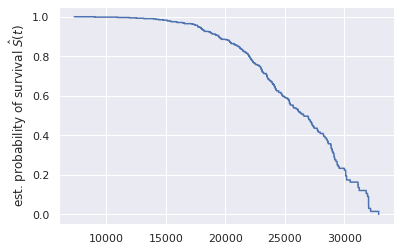

In [4]:
#K-M plot
time, survival_prob = kaplan_meier_estimator(df["vital_status"], df["days_to_birth"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")

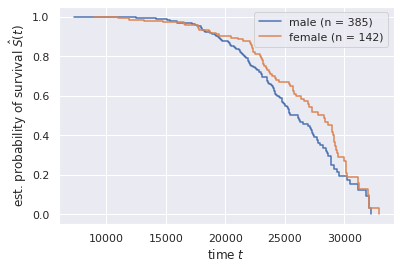

In [5]:
#separated by gender
for value in df["gender"].unique():
    mask = df["gender"] == value
    time, survival_prob = kaplan_meier_estimator(df["vital_status"][mask], df["days_to_birth"][mask])
    plt.step(time, survival_prob, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

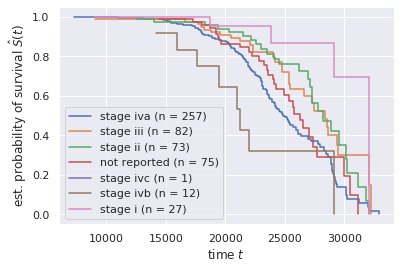

In [6]:
#separated by tumor_stage
for value in df["tumor_stage"].unique():
    mask = df["tumor_stage"] == value
    time, survival_prob = kaplan_meier_estimator(df["vital_status"][mask], df["days_to_birth"][mask])
    plt.step(time, survival_prob, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [7]:
#tumor_stage grouping
stage_group = {
    'stage i':'stage i~ii',
    'stage ii':'stage i~ii',
    'stage iii':'stage iii~iv',
    'stage iva':'stage iii~iv',
    'stage ivb':'stage iii~iv',
    'stage ivc':'stage iii~iv',
    'not reported':'not reported'
}

df["tumor_group"] = df["tumor_stage"].apply(lambda x: stage_group[x])

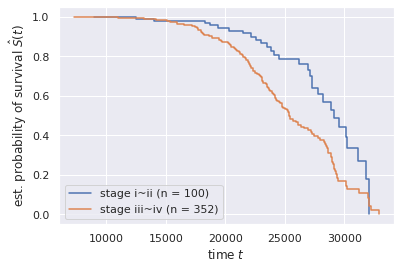

In [8]:
#separated by grouped tumor_stage
for value in ("stage i~ii", "stage iii~iv"):
    mask = df["tumor_group"] == value
    time, survival_prob = kaplan_meier_estimator(df["vital_status"][mask], df["days_to_birth"][mask])
    plt.step(time, survival_prob, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

---

In [9]:
#'days_to_birth','tissue_or_organ_of_origin','morphology','race','tumor_stage','gender','primary_diagnosis'
df2 = df.loc(axis=1)["vital_status","days_to_birth",'gender','race']

#one hot encoding
df2.iloc(axis=1)[0] = df2.iloc(axis=1)[0].astype('category')
df2.iloc(axis=1)[1] = df2.iloc(axis=1)[1].astype('int')
for i in range(2,df2.shape[1]):
    df2.iloc(axis=1)[i] = df2.iloc(axis=1)[i].astype('category')

df2_num = OneHotEncoder().fit_transform(df2)
df2_num.head()

,vital_status=True,days_to_birth,gender=male,race=asian,race=black or african american,race=not reported,race=white
0,1.0,17971,1.0,0.0,0.0,0.0,1.0
1,1.0,19518,1.0,0.0,0.0,0.0,1.0
2,1.0,32022,0.0,0.0,0.0,1.0,0.0
3,1.0,23955,1.0,0.0,0.0,0.0,1.0
4,1.0,28466,1.0,0.0,0.0,0.0,1.0


In [10]:
#cox proportional hazards model
cph = CoxPHFitter()
cph.fit(df2_num, duration_col='days_to_birth', event_col='vital_status=True')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 527 observations, 303 censored>
      duration col = 'days_to_birth'
         event col = 'vital_status=True'
number of subjects = 527
  number of events = 224
partial log-likelihood = -1130.02
  time fit was run = 2019-07-24 17:09:07 UTC

---
                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
gender=male                     0.24      1.27      0.15           -0.06            0.53                0.95                1.69
race=asian                     -0.55      0.58      1.12           -2.75            1.65                0.06                5.18
race=black or african american -0.30      0.74      1.02           -2.31            1.70                0.10                5.48
race=not reported              -0.97      0.38      1.09           -3.09            1.16                0.05                3.20
race=white                     -0.86      0.42      1.01           -2.83   

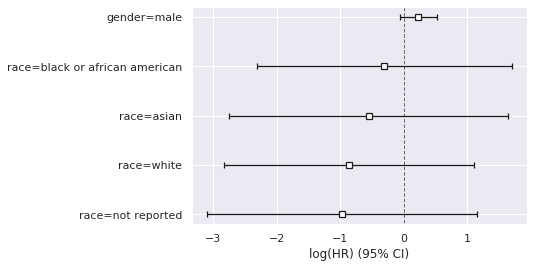

In [11]:
cph.plot()

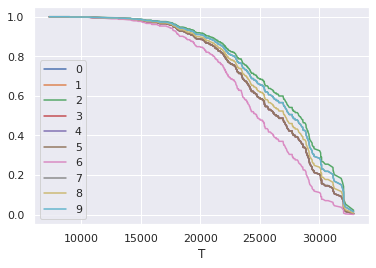

In [12]:
#0~9 sample plot
cph.predict_survival_function(df2_num.iloc[0:10]).plot()